In [ ]:
# !pip install names-dataset

In [ ]:
import torch
from names_dataset import NameDataset
import re
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [ ]:
SEED = 42

# Data

In [ ]:
nd = NameDataset()

In [ ]:
country_codes = ["US", "CA", "GB", "IN"]            # USA, Canada, Great Britain, India

In [ ]:
dataset = set()
dataset_size = 50000
for code in country_codes:
    data = nd.get_top_names(n=dataset_size, country_alpha2=code)
    dataset.update(set(data[code]['M'] + data[code]['F']))

In [ ]:
len(dataset)

43231

In [ ]:
# clean and make each name 1 word
names = list()
for name in dataset:
    if re.match(r"^[A-Za-z\s]+$", name):            # only consider names with english alphabets
        for i in name.split():
            if len(i)>1: names.append(i.lower())

# Basic Neural Network model

In [ ]:
names[0]

'orla'

In [ ]:
chars = sorted(list(set(''.join(names))))

In [ ]:
ctoi = {k:idx+1 for idx, k in enumerate(chars)}
ctoi['.'] = 0

In [ ]:
itoc = {v:k for k,v in ctoi.items()}

In [ ]:
# xs are all the inputs to the nn, ys are the corresponding outputs
xs,ys = [], []
for name in names[:2]:
    name = ['.'] + list(name) + ['.']
    print(''.join(name))
    for c1, c2 in zip(name, name[1:]):
        xs.append(c1)
        ys.append(c2)
        print(f"{c1} -----> {c2}")
    print("---------------")
    

.orla.
. -----> o
o -----> r
r -----> l
l -----> a
a -----> .
---------------
.aboubacar.
. -----> a
a -----> b
b -----> o
o -----> u
u -----> b
b -----> a
a -----> c
c -----> a
a -----> r
r -----> .
---------------


In [ ]:
xs,ys = [], []
for name in names:
    name = ['.'] + list(name) + ['.']
    for c1, c2 in zip(name, name[1:]):
        xs.append(ctoi[c1])
        ys.append(ctoi[c2])

xs = torch.tensor(xs)                   # torch.tensor - autodetects the dtype, torch.Tensor defaults to float
ys = torch.tensor(ys)

In [ ]:
xs[:5]

tensor([ 0, 15, 18, 12,  1])

In [ ]:
ys[:5]

tensor([15, 18, 12,  1,  0])

In [ ]:
## can't feed integer index to the nn, so create a vector -> common way is to create a onehot vector
xenc = F.one_hot(xs)

In [ ]:
xenc.shape

torch.Size([306991, 27])

In [ ]:
xenc[:5].shape

torch.Size([5, 27])

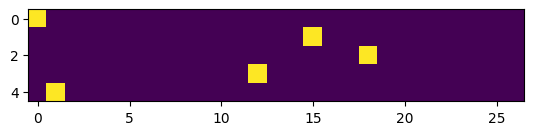

In [ ]:
plt.imshow(xenc[:5])

In [ ]:
xenc.dtype

torch.int64

In [ ]:
## can't input integers to nn, so convert to float
xenc = xenc.float()
xenc.dtype

torch.float32

In [ ]:
## let's create a simple single neuron with weights - W
W = torch.randn((27,1))         # each input is (1,27) size, so W is (27,1) so that we can do 'Wx' and spit out the product corresponding to the input
W

tensor([[-1.0689],
        [-0.2569],
        [-0.3249],
        [ 0.5182],
        [-0.5608],
        [ 1.2037],
        [ 0.1602],
        [-0.0324],
        [ 0.1895],
        [ 0.7312],
        [ 0.2050],
        [-0.5482],
        [ 0.0922],
        [ 0.8707],
        [ 1.9514],
        [-2.3171],
        [ 0.4049],
        [ 1.3411],
        [-0.4866],
        [ 0.7615],
        [-0.3826],
        [ 0.2325],
        [-0.5492],
        [-0.0530],
        [-0.0723],
        [ 0.4620],
        [ 0.1041]])

In [ ]:
# ex
xenc[:1] @ W                # '@' matrix multiplication by torch

tensor([[-1.0689]])

In [ ]:
## similarly for a batch of inputs
xenc[:5] @ W          # 5,1

tensor([[-1.0689],
        [-2.3171],
        [-0.4866],
        [ 0.0922],
        [-0.2569]])

In [ ]:
## Let's create 27 neurons - so that we can output 27 dim vector (which can be given to softmax) to highlight the one out of 27 chars
W = torch.randn((27,27), requires_grad=True)        # explicitly set requires_grad so that we can do backprop by calculating grads

In [ ]:
xenc[0] @ W         # should give 27 dim vector

tensor([-0.4744,  0.0674,  1.0105,  0.6498, -0.3584, -1.5673, -1.8801,  0.5003,
        -0.7110, -0.9997,  0.3784,  1.1491,  0.9539, -0.0081, -0.0990, -1.7772,
         0.5131, -0.3394, -1.6720,  0.2915,  0.2621, -0.0053, -0.6830, -0.2243,
        -1.1239, -0.8245,  0.9831], grad_fn=<SqueezeBackward4>)

In [ ]:
# similarly batch
(xenc[:5] @ W).shape

torch.Size([5, 27])

In [ ]:
# we want probability of each char given a prev char
# currently, nn gives some -ve and +ve numbers as outputs
# we had counts in the prev approach which are converted to probabilities
# let's think that the nn outputs the log counts(logits), now this can be converted to probabilty
# exp(inverse of log) the nn output, so that we'll get the counts, then convert the counts to probability by dividing with the sum
# note that all these are differentiable operations, so that we can backprop to optimize the weights

In [ ]:
logits = xenc @ W               # log-counts
logits.shape

torch.Size([306991, 27])

In [ ]:
logits[:2]

tensor([[-0.4744,  0.0674,  1.0105,  0.6498, -0.3584, -1.5673, -1.8801,  0.5003,
         -0.7110, -0.9997,  0.3784,  1.1491,  0.9539, -0.0081, -0.0990, -1.7772,
          0.5131, -0.3394, -1.6720,  0.2915,  0.2621, -0.0053, -0.6830, -0.2243,
         -1.1239, -0.8245,  0.9831],
        [ 0.6808, -0.2723, -0.4479,  1.5656,  1.4405,  0.1476,  0.6211,  0.7006,
          0.6008,  0.7934,  0.8319, -0.9536, -0.2047,  1.2169, -0.7423, -2.2152,
         -0.6619,  0.2168, -0.0423,  2.4974,  0.0527,  1.2078,  2.2832, -0.6594,
          0.6610,  0.2582, -0.5172]], grad_fn=<SliceBackward0>)

In [ ]:
counts = logits.exp()               # from 0 to inf
counts[:2]                          # counts is equivalent to 'N' matrix in the prev approach

tensor([[ 0.6222,  1.0697,  2.7470,  1.9152,  0.6988,  0.2086,  0.1526,  1.6493,
          0.4911,  0.3680,  1.4600,  3.1553,  2.5957,  0.9920,  0.9057,  0.1691,
          1.6704,  0.7122,  0.1879,  1.3385,  1.2996,  0.9947,  0.5051,  0.7991,
          0.3250,  0.4385,  2.6727],
        [ 1.9755,  0.7616,  0.6390,  4.7857,  4.2228,  1.1591,  1.8610,  2.0149,
          1.8236,  2.2109,  2.2977,  0.3853,  0.8149,  3.3765,  0.4760,  0.1091,
          0.5159,  1.2421,  0.9586, 12.1505,  1.0541,  3.3461,  9.8080,  0.5171,
          1.9367,  1.2946,  0.5962]], grad_fn=<SliceBackward0>)

In [ ]:
probs = counts/counts.sum(1, keepdim=True)
probs[:2]

tensor([[0.0206, 0.0355, 0.0911, 0.0635, 0.0232, 0.0069, 0.0051, 0.0547, 0.0163,
         0.0122, 0.0484, 0.1047, 0.0861, 0.0329, 0.0300, 0.0056, 0.0554, 0.0236,
         0.0062, 0.0444, 0.0431, 0.0330, 0.0168, 0.0265, 0.0108, 0.0145, 0.0887],
        [0.0317, 0.0122, 0.0103, 0.0768, 0.0677, 0.0186, 0.0299, 0.0323, 0.0293,
         0.0355, 0.0369, 0.0062, 0.0131, 0.0542, 0.0076, 0.0018, 0.0083, 0.0199,
         0.0154, 0.1949, 0.0169, 0.0537, 0.1573, 0.0083, 0.0311, 0.0208, 0.0096]],
       grad_fn=<SliceBackward0>)

The above 2 cells correspond to the 'softmax' operation - converting logits into probabilities

In [ ]:
probs[0].shape          # probability over all the 27 chars given the 0th training example

torch.Size([27])

In [ ]:
probs[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

Calculating loss - for each prediction, take the probability that model assigns to the correct 'y'[likelihood]

In [ ]:
xs[:5]

tensor([ 0, 15, 18, 12,  1])

In [ ]:
ys[:5]

tensor([15, 18, 12,  1,  0])

In [ ]:
probs[0,1]  # probability of the correct index(y-1) that the model predicted for the 1st(0) training sample

tensor(0.0355, grad_fn=<SelectBackward0>)

In [ ]:
probs[1,18] # probability of the correct index(y-18) that the model predicted for the 2nd(1) training sample

tensor(0.0154, grad_fn=<SelectBackward0>)

In [ ]:
probs[0,1], probs[1,18], probs[2,23], probs[3,5], probs[4,14]

(tensor(0.0355, grad_fn=<SelectBackward0>),
 tensor(0.0154, grad_fn=<SelectBackward0>),
 tensor(0.0290, grad_fn=<SelectBackward0>),
 tensor(0.0032, grad_fn=<SelectBackward0>),
 tensor(0.0317, grad_fn=<SelectBackward0>))

In [ ]:
# efficient way of retrieving the above
range_ = torch.arange(5)    # ideally all the predictions
probs[range_, ys[:5]]       # likelihood

tensor([0.0056, 0.0154, 0.0252, 0.0094, 0.0161], grad_fn=<IndexBackward0>)

In [ ]:
probs[range_, ys[:5]].log() # log likelihood

tensor([-5.1832, -4.1748, -3.6814, -4.6659, -4.1303], grad_fn=<LogBackward0>)

In [ ]:
probs[range_, ys[:5]].log().mean()

tensor(-4.3671, grad_fn=<MeanBackward0>)

In [ ]:
-probs[range_, ys[:5]].log().mean().item()     # avg -ve log likelihood ----> LOSS

4.367127418518066

In [ ]:
loss = -probs[range_, ys[:5]].log().mean()

In [ ]:
loss

tensor(4.3671, grad_fn=<NegBackward0>)

#### Backprop

In [ ]:
# 1. set all gradients to zero

In [ ]:
W.grad = None
loss.backward()

In [ ]:
W.grad

tensor([[ 0.0041,  0.0071,  0.0182,  0.0127,  0.0046,  0.0014,  0.0010,  0.0109,
          0.0033,  0.0024,  0.0097,  0.0209,  0.0172,  0.0066,  0.0060, -0.1989,
          0.0111,  0.0047,  0.0012,  0.0089,  0.0086,  0.0066,  0.0034,  0.0053,
          0.0022,  0.0029,  0.0177],
        [-0.1968,  0.0587,  0.0030,  0.0129,  0.0025,  0.0061,  0.0018,  0.0004,
          0.0035,  0.0054,  0.0092,  0.0122,  0.0060,  0.0017,  0.0063,  0.0002,
          0.0011,  0.0058,  0.0062,  0.0027,  0.0059,  0.0072,  0.0024,  0.0011,
          0.0233,  0.0052,  0.0058],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [ ]:
W.shape

torch.Size([27, 27])

In [ ]:
W.grad.shape        # each value corresponds to the +ve or -ve effect on loss

torch.Size([27, 27])

In [ ]:
W.grad[0,0]     # this has +ve effect of nudging loss to +ve (increase) if we add a +ve constant to this gradient

tensor(0.0041)

In [ ]:
# update the weights(optimize) with the new grads
W.data += -0.1 * W.grad

In [ ]:
logits = xenc @ W 
counts = logits.exp() 
probs = counts/counts.sum(1, keepdim=True)
loss = -probs[range_, ys[:5]].log().mean()      # considering only first 5 samples to speed it up

In [ ]:
loss        # reduces after updation

tensor(4.3460, grad_fn=<NegBackward0>)

In [ ]:
W.grad = None
loss.backward()
W.data += -0.1 * W.grad

In [ ]:
logits = xenc @ W 
counts = logits.exp() 
probs = counts/counts.sum(1, keepdim=True)
loss = -probs[range_, ys[:5]].log().mean() 

In [ ]:
loss    # reduces even further, now we're basically doing gradient descent

tensor(4.3248, grad_fn=<NegBackward0>)

#### lets run on entire training set

In [ ]:
xs.shape, ys.shape

(torch.Size([306991]), torch.Size([306991]))

In [ ]:
num_samples = xs.nelement()
print(f"Total number of training examples - {num_samples}")

Total number of training examples - 306991


In [ ]:
# initialize the network
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [ ]:
def train(num_epochs:int):
    for _ in range(num_epochs):
        # forward pass
        logits = xenc @ W 
        counts = logits.exp() 
        probs = counts/counts.sum(1, keepdim=True)
        loss = -probs[torch.arange(num_samples), ys].log().mean() 
        print(loss.item())
        
        # backward pass
        W.grad = None
        loss.backward()
        
        # update
        W.data += -50 * W.grad      # took large laerning rate to have bigger steps

In [ ]:
train(100)

3.4069812297821045
3.2142512798309326
3.074751377105713
2.9743690490722656
2.901893377304077
2.8478457927703857
2.806061029434204
2.7728171348571777
2.7457494735717773
2.723296642303467
2.7043936252593994
2.6882808208465576
2.674398183822632
2.6623215675354004
2.651726245880127
2.6423592567443848
2.634021282196045
2.6265530586242676
2.619826078414917
2.6137349605560303
2.6081936359405518
2.603130578994751
2.5984861850738525
2.5942108631134033
2.5902628898620605
2.5866057872772217
2.583209991455078
2.5800492763519287
2.577101230621338
2.574345588684082
2.571765422821045
2.569345474243164
2.5670721530914307
2.5649330615997314
2.562917470932007
2.5610156059265137
2.559218645095825
2.557518482208252
2.555907726287842
2.5543806552886963
2.552929639816284
2.55155086517334
2.550238609313965
2.5489883422851562
2.5477964878082275
2.5466582775115967
2.5455715656280518
2.544532060623169
2.5435373783111572
2.5425844192504883
2.5416715145111084
2.5407958030700684
2.5399551391601562
2.53914785385131

Matched the performance of the previous count model but with gradient based optimization

advantage this time - we can take more advanced NN, and take more context length and repeat the same process to improve the performance

In [ ]:
# prediction
g = torch.Generator().manual_seed(SEED)
n = 5 # predict 5 words
for _ in range(n):
    out = []
    ix = 0          # start with '.'
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W 
        counts = logits.exp() 
        probs = counts/counts.sum(1, keepdim=True)
        
        ix = torch.multinomial(probs, generator=g, replacement=True, num_samples=1).item()
        out.append(itoc[ix])
        if ix==0:
            break
    print(''.join(out))

anuguenvt.
s.
mabidushantubun.
silayanaro.
mah.
